# In this notebook, we are going to implement MLP model to analysis the data
## https://en.wikipedia.org/wiki/Multilayer_perceptron


In [131]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


In [132]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [133]:
#preprocess labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
4012  HAM_0004359  ISIC_0025087   nv  follow_up  50.0  female   
6066  HAM_0000628  ISIC_0024567   nv  follow_up  35.0  female   
3390  HAM_0002286  ISIC_0029876   nv  follow_up  40.0  female   
8222  HAM_0003387  ISIC_0028524   nv      histo  25.0  female   
2481  HAM_0003429  ISIC_0028807  bcc      histo  70.0    male   

         localization  label  
4012             neck      5  
6066  lower extremity      5  
3390            trunk      5  
8222          abdomen      5  
2481             back      1  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [246]:
import math
#assign weight
#sum of the data
total_data = 0
num_classes = 7
for num_of_data in df['label'].value_counts():
    total_data+=num_of_data
print("total number of data: ",total_data)
print(df['label'].value_counts())
#calc weight for each class
class_weight ={}
for index, value in df.label.value_counts().iteritems():
    v1 = math.log(total_data/(float(value)*num_classes))
    class_weight[index] = v1 if v1>1.0 else 1.0

for i in class_weight:
    print(i," ",class_weight[i])

total number of data:  10015
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
5   1.0
4   1.0
2   1.0
1   1.0237058335894402
0   1.4759689281473518
6   2.310102041443345
3   2.520996970681355


In [210]:
from glob import glob
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [211]:
#image_64 is the actual image(resized to 64x64) store in the dataframe
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

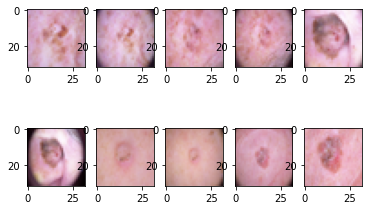

In [137]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [358]:
#image to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split

df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
data = data.reshape(total_data,image_size*image_size*3).astype('float32')
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.2,random_state=random.randint(1,99),stratify=label_to_one_hot)

In [359]:
#setup MLP model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Dense
num_classes = 7
dimension = image_size*image_size*3

model = Sequential()

#input Dense layer of 64x64x3 image input:
#with normal distribution + relu activation
model.add(Dense(units=1024,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.15))

#hidden layer 2
model.add(Dense(units=256,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))

#hidden layer 3
model.add(Dense(units=64,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.25))

#hidden layer 4
#model.add(Dense(units=128,input_dim=dimension,kernel_initializer='normal',activation='relu'))
#model.add(Dropout(0.25))

#output Dense layer with 7 classes + softmax activation
model.add(Dense(units=num_classes,kernel_initializer='normal',activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 1024)              3146752   
_________________________________________________________________
dropout_142 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_193 (Dense)            (None, 256)               262400    
_________________________________________________________________
dropout_143 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_194 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_144 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_195 (Dense)            (None, 7)               

In [360]:
# Train


batch_size = 512
epochs = 200

train_history = model.fit(
    x=train_data,y=train_label,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2,class_weight=class_weight)

Epoch 1/200
13/13 - 1s - loss: 1.5334 - acc: 0.6066 - val_loss: 1.1534 - val_acc: 0.6575
Epoch 2/200
13/13 - 0s - loss: 1.3382 - acc: 0.6700 - val_loss: 1.0936 - val_acc: 0.6575
Epoch 3/200
13/13 - 0s - loss: 1.2675 - acc: 0.6705 - val_loss: 1.0836 - val_acc: 0.6575
Epoch 4/200
13/13 - 0s - loss: 1.2173 - acc: 0.6712 - val_loss: 1.0533 - val_acc: 0.6575
Epoch 5/200
13/13 - 0s - loss: 1.2044 - acc: 0.6720 - val_loss: 1.0265 - val_acc: 0.6575
Epoch 6/200
13/13 - 0s - loss: 1.1807 - acc: 0.6726 - val_loss: 1.0270 - val_acc: 0.6575
Epoch 7/200
13/13 - 0s - loss: 1.1742 - acc: 0.6720 - val_loss: 0.9999 - val_acc: 0.6575
Epoch 8/200
13/13 - 0s - loss: 1.1625 - acc: 0.6723 - val_loss: 1.0004 - val_acc: 0.6575
Epoch 9/200
13/13 - 0s - loss: 1.1431 - acc: 0.6717 - val_loss: 0.9711 - val_acc: 0.6575
Epoch 10/200
13/13 - 0s - loss: 1.1249 - acc: 0.6709 - val_loss: 0.9673 - val_acc: 0.6575
Epoch 11/200
13/13 - 0s - loss: 1.1239 - acc: 0.6723 - val_loss: 0.9563 - val_acc: 0.6575
Epoch 12/200
13/13 

In [141]:
# Train without class weight

batch_size = 256
epochs = 20

train_history_2 = model.fit(
    x=train_data,y=train_label,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2)

Epoch 1/20
24/24 - 1s - loss: 0.9431 - acc: 0.6716 - val_loss: 0.8825 - val_acc: 0.6860
Epoch 2/20
24/24 - 1s - loss: 0.9324 - acc: 0.6704 - val_loss: 0.8844 - val_acc: 0.6866
Epoch 3/20
24/24 - 1s - loss: 0.9320 - acc: 0.6718 - val_loss: 0.8941 - val_acc: 0.6846
Epoch 4/20
24/24 - 1s - loss: 0.9253 - acc: 0.6751 - val_loss: 0.8891 - val_acc: 0.6833
Epoch 5/20
24/24 - 1s - loss: 0.9205 - acc: 0.6691 - val_loss: 0.8653 - val_acc: 0.6893
Epoch 6/20
24/24 - 1s - loss: 0.9129 - acc: 0.6729 - val_loss: 0.8643 - val_acc: 0.6873
Epoch 7/20
24/24 - 1s - loss: 0.9182 - acc: 0.6726 - val_loss: 0.9426 - val_acc: 0.6933
Epoch 8/20
24/24 - 1s - loss: 0.9152 - acc: 0.6754 - val_loss: 0.8604 - val_acc: 0.6913
Epoch 9/20
24/24 - 1s - loss: 0.9169 - acc: 0.6719 - val_loss: 0.8950 - val_acc: 0.6820
Epoch 10/20
24/24 - 0s - loss: 0.9261 - acc: 0.6721 - val_loss: 0.8641 - val_acc: 0.6906
Epoch 11/20
24/24 - 0s - loss: 0.9040 - acc: 0.6736 - val_loss: 0.8604 - val_acc: 0.6900
Epoch 12/20
24/24 - 0s - loss:

In [256]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

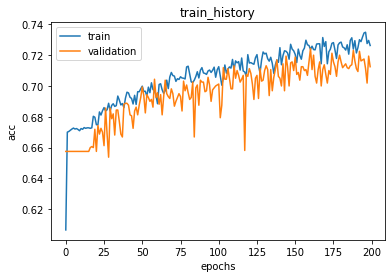

In [361]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

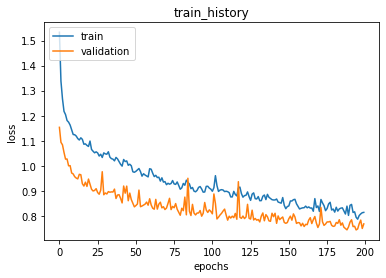

In [362]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [363]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

63/63 [==============================] - 0s 2ms/step - loss: 0.7564 - acc: 0.7204
Test accuracy: 0.7204193472862244


In [364]:
#predictions

prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
print(prediction_class)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))

[5 5 5 ... 5 5 4]
predict   0   1   2  3   4     5   6
label                               
0        15  11  10  1   5    23   0
1        10  32  10  1   3    40   7
2        12   5  61  0   5   135   2
3         3   4   2  2   0    12   0
4         4   1  17  1  30   168   2
5         8   3  25  1  15  1285   4
6         2   2   0  0   0     6  18
